# 第三次计算物理作业

学号： 2021300002018

姓名： 朱向阳

# 2.11 
在战争中，通常希望击中特定目标（而不是让炮弹随意落地）。然而，由于任何参数的微小变化都可能导致炮弹的落点大幅改变，这并不容易。通过计算在本节中考虑的炮弹的射程如果初始速度增加1％会发生多大变化来研究这一点。还计算如果有轻微的（$(10 \mathrm{~km} / \mathrm{h})$）风，射程的变化情况（可以使用下一节中开发的方法添加此效应）。你应该会发现，即使这些相对较小的变化也会显着改变落点。

为尽量模拟实际情况，采用《火炮弹道学》中的公式与数据.

同时考虑**地球曲率**、**科里奥利力**、**重力加速度随高度变化**及**风速**时的微分方程组：

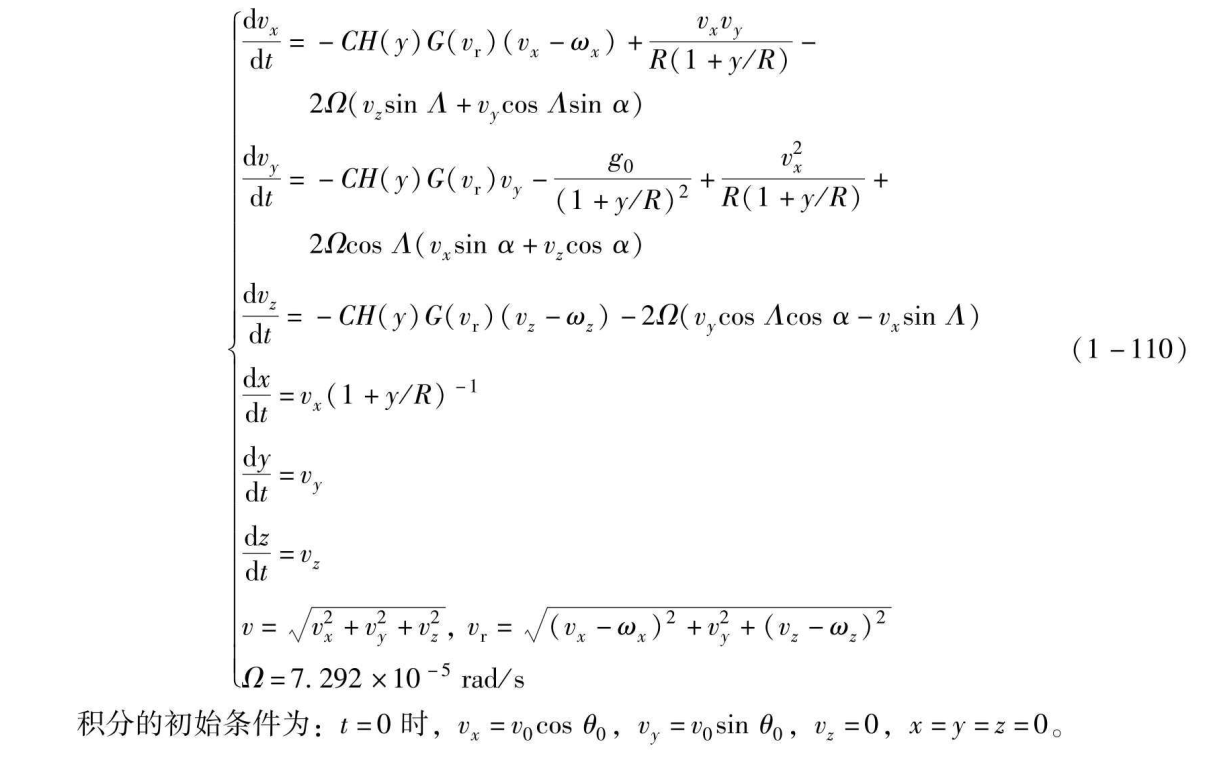

式中各项分别为：
1. 风速

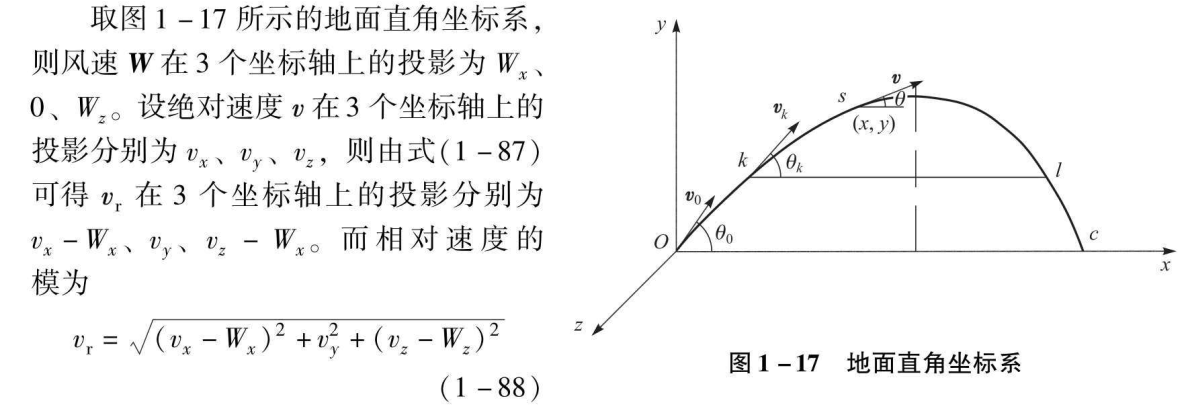

2. 气温标准分布公式

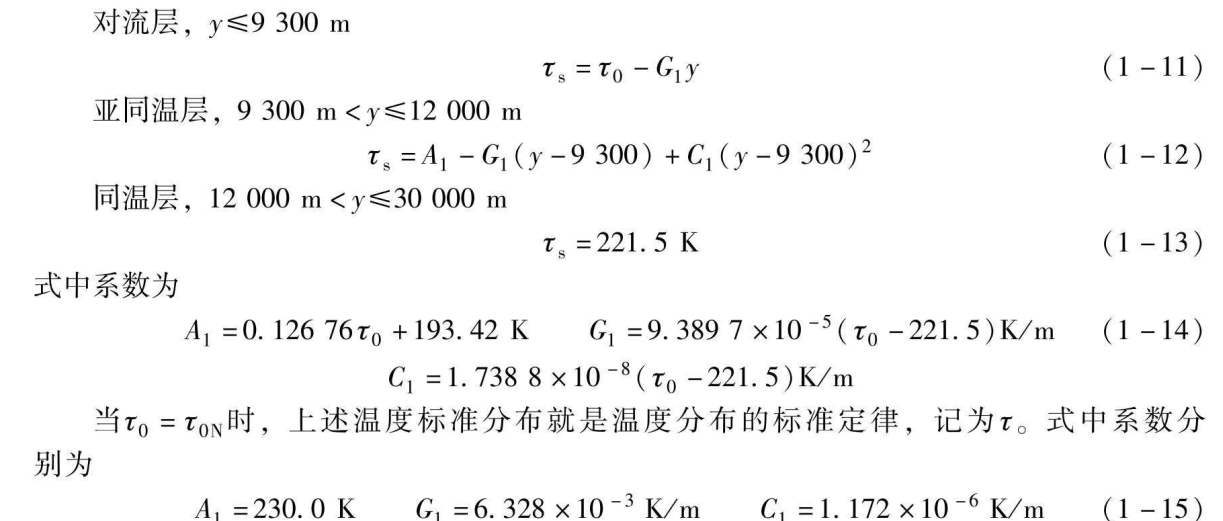

3. 气压、密度标准分布公式

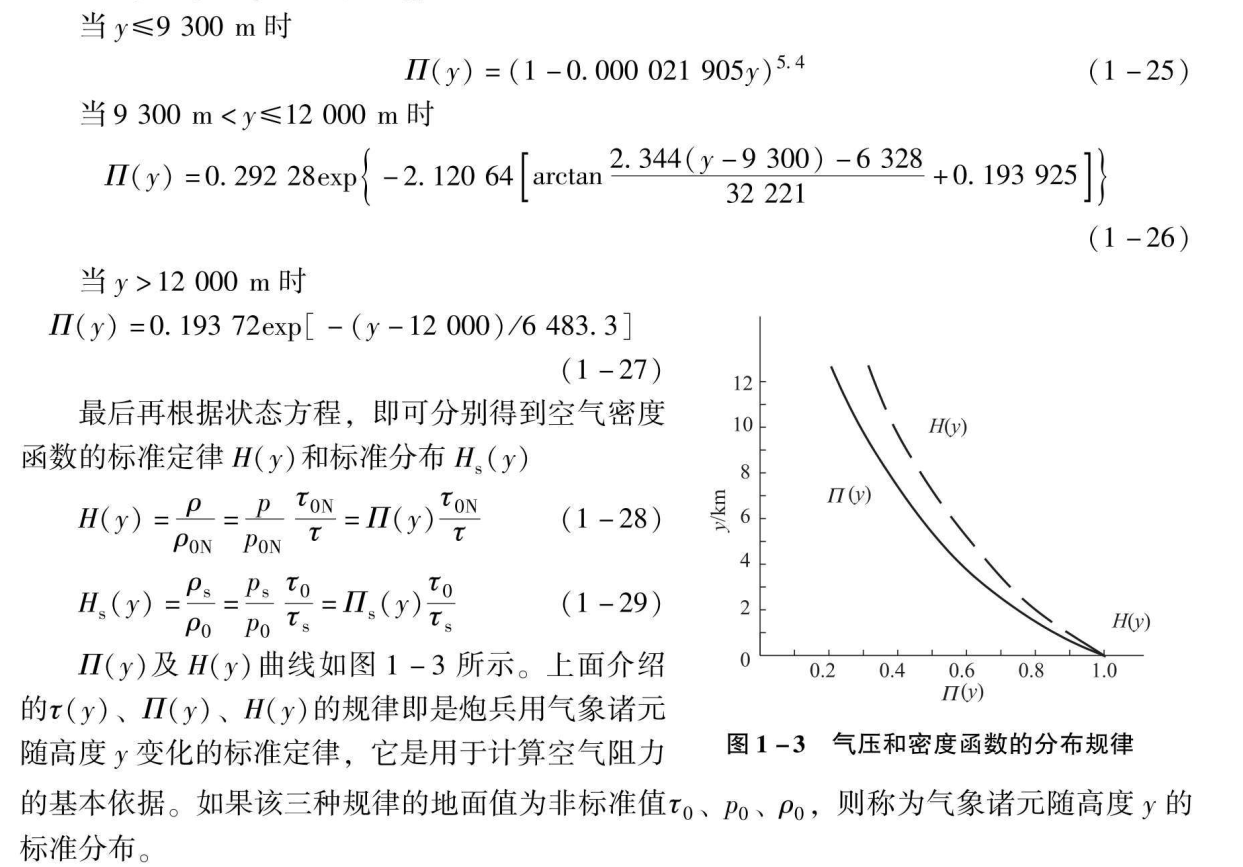

4. 阻力公式

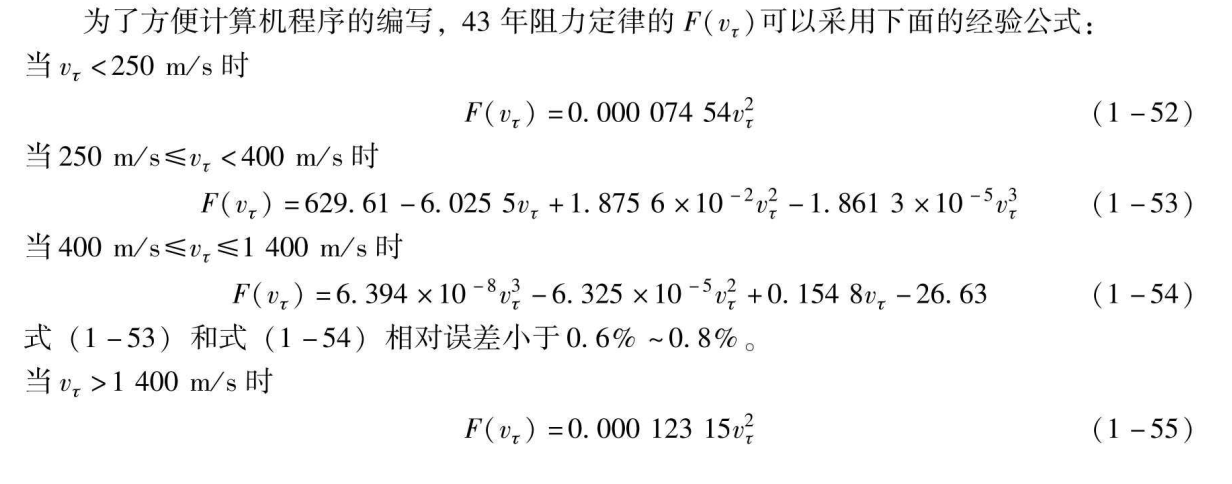

In [155]:
# 导入常用包
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math as m

In [156]:
# 温度函数
class Temp:
    def __init__(self, p0N = 1e5, a0N = 846.7, 
                 Phi = 0.5, tau0N = 288.9, rho0N = 1.206) -> None:
        self.p0N = p0N
        self.a0N = a0N
        self.Phi = Phi
        self.tau0N = tau0N
        self.rho0N = rho0N # 气象诸元标准值
        self.A1 = 0.12676 * self.tau0N + 193.42
        self.G1 = 9.3897 * 1e-5 * (self.tau0N - 221.5)
        self.C1 = 1.7388 * 1e-8 * (self.tau0N - 221.5)

    def taus(self, height):
        t = 273.15
        if height <= 9300:
            t = self.tau0N - self.G1 * height
        elif height <= 12000 and height > 9300:
            t = self.A1 - self.G1 * (height - 9300) + self.C1 * (height - 9300) **2
        elif height <= 30000 and height > 1200:
            t = 221.5
        return t

In [157]:
# 密度函数
class Rho(Temp):
    def __init__(self, p0N = 1e5, a0N = 846.7, 
                 Phi = 0.5, tau0N = 288.9, rho0N = 1.206,
                 g = 9.97361, Rair = 287, t = 0) -> None:
        super(Rho, self).__init__(p0N, a0N, Phi, tau0N, rho0N)
        self.g = g
        self.Rair = Rair
        self.t = t
        self.B2 = m.sqrt(4 * self.A1 * self.C1 - self.G1 **2)
        self.B1 = 2 * self.g / (self.Rair * self.B2)

    def rho(self, height):
        p = 1
        if self.t == 0:
            self.t = self.taus(height = height)
        if height <= 9300:
            p = (1 - self.G1 / self.tau0N * height) ** (self.g / (self.Rair * self.G1))
        elif height <= 12000 and height > 9300:
            p = (1 - 9300 * self.G1 / self.tau0N) ** (self.g / (self.Rair * self.G1)) * m.exp(- self.B1 * (m.atan((2 * self.C1 * (height - 9300)-self.G1)/self.B2) + m.atan(self.G1/self.B2)))
        elif height <= 30000 and height > 1200:
            p = (1 - 9300 * self.G1 / self.tau0N) ** (self.g / (self.Rair * self.G1)) * m.exp(- self.B1 * (m.atan((2 * self.C1 * (height - 9300)-self.G1)/self.B2) + m.atan(self.G1/self.B2))) * m.exp(-(self.g * (height-12000))/(221.5 * self.Rair))
        return p

In [158]:
# 标准空气密度函数
class RhoH(Rho):
    def HRho(self, height, tauss = 0):
        if tauss == 0:
            tauss = self.taus(height = height)
        return self.rho(height = height) * self.tau0N / tauss

In [160]:
# 空气阻力函数
class Frction:
    def __init__(self) -> None:
        pass

    def value(self, v):
        if v < 250:
            f = 7.454 * 1e-5 * (v**2)
        elif v >= 250 and v < 400:
            f = 629.61-6.0255 * v + 1.8756*1e-2*(v**2)
        elif v >= 400 and v <= 1400:
            f = 6.394*1e-8*(v**3)-6.325*1e-5*(v**2) + 0.1548*v-26.63
        elif v > 1400:
            f = 1.2315 * 1e-4 * (v**2)
        g = f / v
        return g

In [161]:
# 风速
class Wind:
    def __init__(self, Wx = 3, Wy = 0, Wz = 3) -> None:
        self.Wx = Wx
        self.Wy = Wy
        self.Wz = Wz
    
    def vr(self, vx, vy, vz):
        return m.sqrt((vx-self.Wx)**2 + vy **2 + (vz-self.Wz)**2)

In [159]:
# 炮弹参数
bullets = {'85mm': {'v0': 793, 'm': 9.540, 'theta': 35, 'C': 0.796},
          '100mm': {'v0': 900, 'm': 15.60, 'theta': 40, 'C': 0.702},
          '122mm': {'v0': 515, 'm': 21.80, 'theta': 45, 'C': 0.708},
          '130mm': {'v0': 885, 'm': 27.30, 'theta': 50, 'C': 0.522},
          '152mm': {'v0': 655, 'm': 43.56, 'theta': 55, 'C': 0.821},
          '60mm': {'v0': 138, 'm': 1.310, 'theta': 60, 'C': 2.137}}

In [173]:
# 初始值
dt = 0.001
time = 1000
max_steps = int(time / dt) 

R = 6371 * 1e3 # 地球半径
gamma = m.radians(40) # 纬度
alpha = m.radians(10) # 与正北方向夹角
omega = 7.292 * 1e-5 # 地球自转角速度
g0 = 9.97361

H = RhoH()
G = Frction()
W = Wind(Wx=2, Wy=0, Wz=2)

In [176]:
# 平凡欧拉
def trajectory(x0, y0, z0, v0, theta, gamma, alpha, omega, R, H, C, G, W, dt, g0, max_steps):

    # declare the arrays we will need
    x = np.zeros(max_steps + 1, dtype = np.float64)
    y = np.zeros(max_steps + 1, dtype = np.float64)
    z = np.zeros(max_steps + 1, dtype = np.float64)
    vx = np.zeros(max_steps + 1, dtype = np.float64)
    vy = np.zeros(max_steps + 1, dtype = np.float64)
    vz = np.zeros(max_steps + 1, dtype = np.float64)
    t = np.zeros(max_steps + 1, dtype = np.float64)

    # initialize variables
    x[0] = x0
    y[0] = y0
    z[0] = z0
    vx[0] = v0*np.cos(theta/180*np.pi)
    vy[0] = v0*np.sin(theta/180*np.pi)
    vz[0] = 0

    sing = np.sin(gamma)
    cosg = np.cos(gamma)
    sina = np.sin(alpha)
    cosa = np.cos(alpha)

    # 欧拉
    for i in range(max_steps):
        vr = W.vr(vx = vx[i], vy = vy[i], vz = vz[i])
        dvx = - C * H.HRho(y[i]) * G.value(vr) * (vx[i] - W.Wx) + (vx[i]*vy[i])/(R*(1+y[i]/R)) - 2 * omega * (vz[i]*sing+vy[i]*cosg*sina)

        dvy = - C * H.HRho(y[i]) * G.value(vr) * vy[i] - g0 / ((1+y[i]/R)**2) + (vx[i]**2) / (R*(1+y[i]/R)) + 2 * omega * cosg * (vx[i]*sina+vz[i]*cosa)

        dvz = - C * H.HRho(y[i]) * G.value(vr) * (vz[i] - W.Wz) - 2 * omega * (vy[i]*cosg*cosa-vx[i]*sing)

        dx = vx[i] / (1+y[i]/R)

        dy = vy[i]

        dz = vz[i]

        vx[i + 1] = vx[i] + dt * dvx
        vy[i + 1] = vy[i] + dt * dvy
        vz[i + 1] = vz[i] + dt * dvz

        x[i + 1] = x[i] + dt * dx
        y[i + 1] = y[i] + dt * dy
        z[i + 1] = z[i] + dt * dz


        if y[i + 1] < 0:
            break

    return x, y, z, i

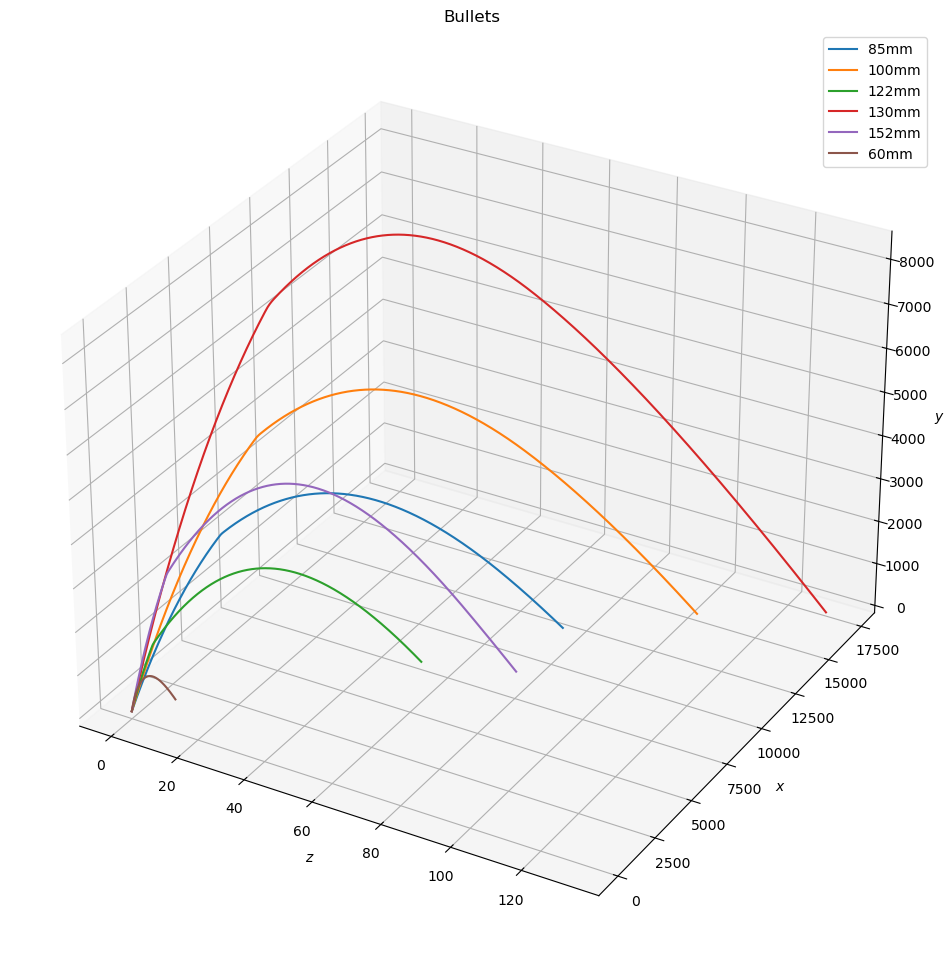

In [181]:
# 绘图，取x轴正方形为正北，z轴正方向为正西， y轴为竖直轴
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_title('Bullets')

for bullet in bullets:
    x, y, z, i = trajectory(x0=0, y0=0, z0=0, v0=bullets[bullet]['v0'], 
                         theta=bullets[bullet]['theta'], gamma=gamma, alpha=alpha, omega=omega, R=R, H=H, C=bullets[bullet]['C'], G=G, W=W, dt=dt, g0=g0, max_steps=max_steps)
    # print(x, y, z)
    ax.plot3D(z[:i], x[:i], y[:i], label=bullet)

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$y$')
ax.legend()
plt.show()


# 2.16. 
估计在没有任何风的情况下，在海平面上击出一个550英尺的全垒打所需的初始速度。在派克峰上，这个球会飞多远？

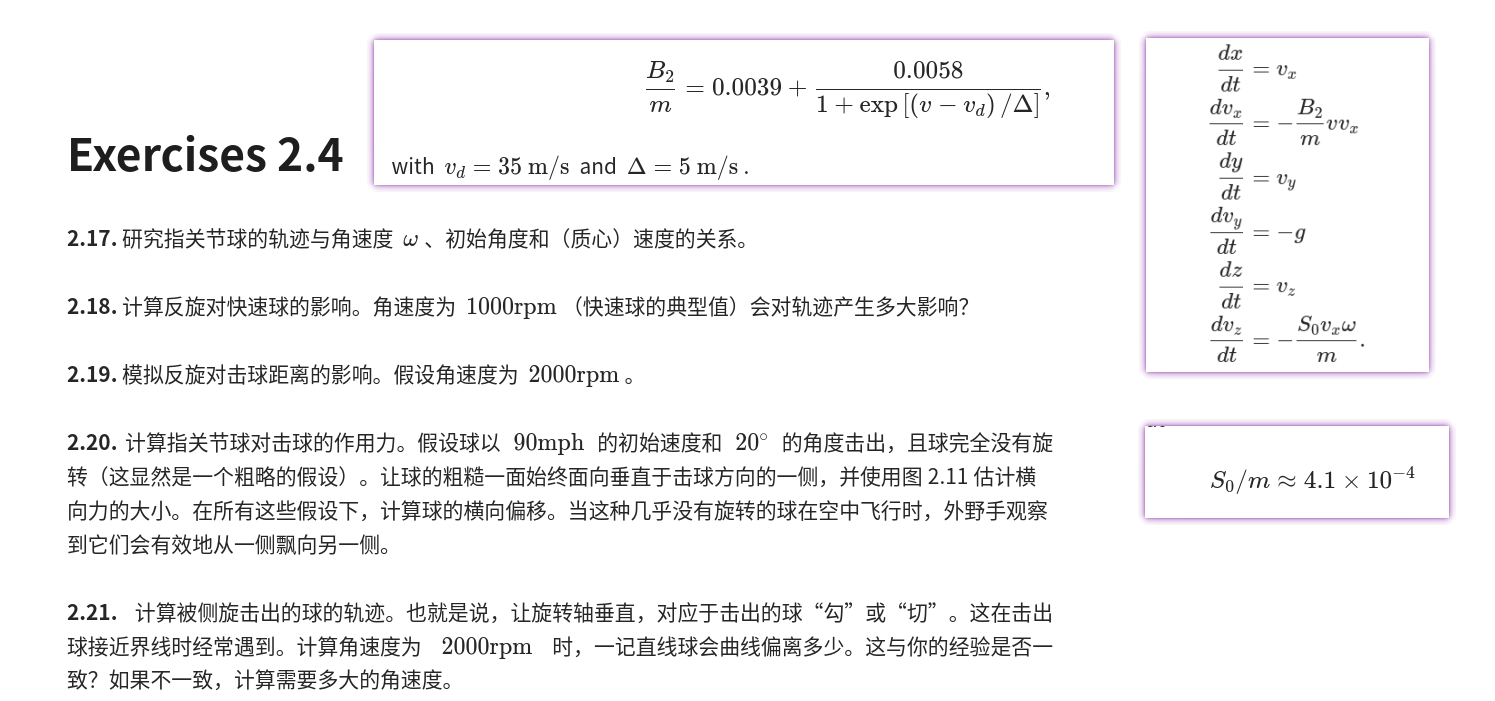

In [183]:
# 导入常用包
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math as m

In [184]:
# 初始值
dt = 0.001
time = 1000
max_steps = int(time / dt) 

vd = 35
delta = 5
omega = (2000 / 60) * 2 * np.pi
g0 = 9.97361
S0m = 4.1 * 1e-4
theta = 45

In [194]:
# 平凡欧拉求最大值
def trajectory(x0, y0, z0, v0, vd, delta, omega, g0, S0m, max_steps, xmax):

    # declare the arrays we will need
    x = np.zeros(max_steps + 1, dtype = np.float64)
    y = np.zeros(max_steps + 1, dtype = np.float64)
    z = np.zeros(max_steps + 1, dtype = np.float64)
    vx = np.zeros(max_steps + 1, dtype = np.float64)
    vy = np.zeros(max_steps + 1, dtype = np.float64)
    vz = np.zeros(max_steps + 1, dtype = np.float64)
    t = np.zeros(max_steps + 1, dtype = np.float64)

    # initialize variables
    x[0] = x0
    y[0] = y0
    z[0] = z0
    vx[0] = v0*np.cos(theta/180*np.pi)
    vy[0] = v0*np.sin(theta/180*np.pi)
    vz[0] = 0

    # 欧拉
    for i in range(max_steps):
        v = np.sqrt(vx[i] ** 2 + vy[i] ** 2 + vz[i] ** 2)

        dvx = - (0.0039 + 0.0058 / (1 + m.exp((v - vd)/delta))) * v * vx[i]

        dvy = -g0

        dvz = -S0m * omega * vx[i]

        dx, dy, dz = vx[i], vy[i], vz[i]

        vx[i + 1] = vx[i] + dt * dvx
        vy[i + 1] = vy[i] + dt * dvy
        vz[i + 1] = vz[i] + dt * dvz

        x[i + 1] = x[i] + dt * dx
        y[i + 1] = y[i] + dt * dy
        z[i + 1] = z[i] + dt * dz


        if y[i + 1] < 0 or x[i + 1] > xmax:
            break

    return x, i

In [198]:
# 普通的二分查找
xmax = 164.64 # 550ft
hpak = 4300
eps = 0.001 # 查找精度
ub0 = ub = 1000
lb0 = lb = 10

while True:
    v0 = (ub + lb) / 2
    x, i = trajectory(x0=0, y0=0, z0=0, v0=v0, vd=vd, delta=delta, omega=omega, g0=g0, S0m=S0m, max_steps=max_steps, xmax=xmax)
    if (x[i + 1] - xmax) > eps:
        ub = (ub + lb) / 2
    elif (x[i + 1] - xmax) < 0:
        lb = (ub + lb) / 2
    else:
        x, i = trajectory(x0=0, y0=hpak, z0=0, v0=v0, vd=vd, delta=delta, omega=omega, g0=g0, S0m=S0m, max_steps=max_steps, xmax=10000000)
        print('所需的最小v0为：', v0, 'm/s')
        print('在派克峰上不考虑其他影响情况下距离为：', x[i + 1], 'm')
        break
        

所需的最小v0为： 71.875 m/s
在派克峰上不考虑其他影响情况下距离为： 218.36176112440043 m
